In [1]:
import networkx as nx
import pandas as pd
import os
import random
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

import numpy as np
import time
import random
from sklearn.metrics import f1_score
from collections import defaultdict 
from dgl.nn import SAGEConv
import scipy.sparse as sp
import json
import seaborn as sns
import matplotlib.pyplot as plt

Using backend: pytorch


In [2]:
import dgl
from dgl.data.utils import save_graphs
from dgl import load_graphs

In [3]:
from dgl.nn import SAGEConv
import dgl.data

In [4]:
#%autosave 0

# EDA

In [5]:
numerical = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',]
categorical = ['key', 'mode', 'time_signature']

In [6]:
data_path = (os.path.join(os.path.expanduser('~'), '/teams/DSC180A_FA21_A00/a13group1/data/'))

In [60]:
def wowa(thelist):
    eligible = []
    for x in thelist:
        nums = pd.Series(x.strip('mpd.slice.json').split('-')).astype(int)
        if nums[0] <= 9999:
            eligible.append(x)
    return eligible

In [61]:
wowa(pd.Series(os.listdir(os.path.join(os.path.expanduser('~'), '/teams/DSC180A_FA21_A00/a13group1/data/'))))

['mpd.slice.4000-4999.json',
 'mpd.slice.9000-9999.json',
 'mpd.slice.0-999.json',
 'mpd.slice.1000-1999.json',
 'mpd.slice.8000-8999.json',
 'mpd.slice.5000-5999.json',
 'mpd.slice.3000-3999.json',
 'mpd.slice.7000-7999.json',
 'mpd.slice.6000-6999.json',
 'mpd.slice.2000-2999.json']

In [81]:
what = np.random.choice(os.listdir(os.path.join(os.path.expanduser('~'), '/teams/DSC180A_FA21_A00/a13group1/data/')), replace=True)
what

'mpd.slice.210000-210999.json'

In [63]:
%%time
# Saving sample of playlists
playlists = []
for i in range(200):
    file_samp = np.random.choice(wowa(pd.Series(os.listdir(os.path.join(os.path.expanduser('~'), '/teams/DSC180A_FA21_A00/a13group1/data/')))), replace=True)
    fname = os.path.join(data_path, file_samp)
    with open(fname) as f:
        data = json.load(f)
        item = np.random.choice(data['playlists'])
        playlists.append(item)

CPU times: user 1min 17s, sys: 5.46 s, total: 1min 23s
Wall time: 1min 23s


In [10]:
# with open("" + 'mpd.slice.{}-{}.json'.format(0, 999)) as f:
#         data = json.load(f)
#         playlists = data['playlists']

In [64]:
std_scaler = StandardScaler()
one_hot = OneHotEncoder()

In [65]:
edafeats = pd.read_csv('~/teams/DSC180A_FA21_A00/a13group1/songset_features_170k')
edafeats = edafeats.drop(columns=['Unnamed: 0', 'type', 'track_href', 'analysis_url'])

edafeats['loudness'] = std_scaler.fit_transform(edafeats[['loudness']])
edafeats['tempo'] = std_scaler.fit_transform(edafeats[['tempo']])
edafeats['duration_ms'] = std_scaler.fit_transform(edafeats[['duration_ms']])

In [66]:
playlists[0]['tracks'][7]

{'pos': 7,
 'artist_name': 'Redbone',
 'track_uri': 'spotify:track:7x46AiwIPkngCwFAu1OCey',
 'artist_uri': 'spotify:artist:0w7HLMvZOHatWVbAKee1zF',
 'track_name': 'Come And Get Your Love',
 'album_uri': 'spotify:album:22nTY0KxYo0VURVfIOWnB8',
 'duration_ms': 208306,
 'album_name': 'K-tel Presents Redbone - One More Time'}

In [68]:
%%time
feat_vars = {'danceability': [], 'energy': [], 'loudness': [], 'speechiness': [], 'acousticness': [], 'instrumentalness': [], 'liveness': [], 'valence': [], 'tempo': [], 'duration_ms': [],'key': [], 'mode': [], 'time_signature': []}
feat_avgs = {'danceability': [], 'energy': [], 'loudness': [], 'speechiness': [], 'acousticness': [], 'instrumentalness': [], 'liveness': [], 'valence': [], 'tempo': [], 'duration_ms': [],'key': [], 'mode': [], 'time_signature': []}
feat_difs = {'danceability': [], 'energy': [], 'loudness': [], 'speechiness': [], 'acousticness': [], 'instrumentalness': [], 'liveness': [], 'valence': [], 'tempo': [], 'duration_ms': [],'key': [], 'mode': [], 'time_signature': []}
feat_ranges = {'danceability': [], 'energy': [], 'loudness': [], 'speechiness': [], 'acousticness': [], 'instrumentalness': [], 'liveness': [], 'valence': [], 'tempo': [], 'duration_ms': [],'key': [], 'mode': [], 'time_signature': []}

for item in playlists:
    #item = playlists[each]
    
    row_ids = []
    for i in item['tracks']:
        row = edafeats[edafeats['uri'] == i['track_uri']].index.item()
        row_ids.append(row)
        
    
    cur_feats = edafeats.iloc[row_ids]
    
    for i in numerical:
        var = np.var(cur_feats[i])
        feat_vars[i].append(var)
        
        avg = np.mean(cur_feats[i])
        feat_avgs[i].append(avg)
        
        difs = np.mean(np.abs(cur_feats[i].diff())[1:])
        feat_difs[i].append(difs)
        
        ranges = np.abs(np.max(cur_feats[i]) - np.min(cur_feats[i]))
        feat_ranges[i].append(ranges)
        
        
        
    for i in categorical:
        highest = max(cur_feats[i].value_counts() / cur_feats[i].count())
        feat_vars[i].append(highest)

CPU times: user 2min 22s, sys: 552 ms, total: 2min 23s
Wall time: 2min 23s


In [69]:
feat_avgs.pop('key')
feat_avgs.pop('mode')
feat_avgs.pop('time_signature')

feat_difs.pop('key')
feat_difs.pop('mode')
feat_difs.pop('time_signature')

feat_ranges.pop('key')
feat_ranges.pop('mode')
feat_ranges.pop('time_signature')

[]

In [70]:
for i in list(feat_vars.keys()):
    print(i, np.mean(feat_vars[i]))

danceability 0.017329077698438947
energy 0.028414555909088337
loudness 0.3663747215698779
speechiness 0.006226121899485901
acousticness 0.05154708668965324
instrumentalness 0.02799155975513185
liveness 0.021205700368190073
valence 0.04239055150395119
tempo 0.9049536230117919
duration_ms 0.3124122826286209
key 0.2052029426522347
mode 0.6988755045165259
time_signature 0.9276849233823583


In [71]:
for i in list(feat_avgs.keys()):
    print(i, len(feat_avgs[i]))

danceability 200
energy 200
loudness 200
speechiness 200
acousticness 200
instrumentalness 200
liveness 200
valence 200
tempo 200
duration_ms 200


In [72]:
for i in list(feat_difs.keys()):
    print(i, len(feat_difs[i]))

danceability 200
energy 200
loudness 200
speechiness 200
acousticness 200
instrumentalness 200
liveness 200
valence 200
tempo 200
duration_ms 200


In [73]:
for i in list(feat_ranges.keys()):
    print(i, len(feat_ranges[i]))

danceability 200
energy 200
loudness 200
speechiness 200
acousticness 200
instrumentalness 200
liveness 200
valence 200
tempo 200
duration_ms 200


# Within Playlists EDA (From 200 Song Sample)

When plotting the distribution of variance for danceability of the 200 sampled playlists we can see that it follows a sort of bimodal distribution, where the variance is always quite low. This suggests that the songs within each playlist follow a sort of similarity in danceability. As we plot the variances of the other playlists we can get different values.

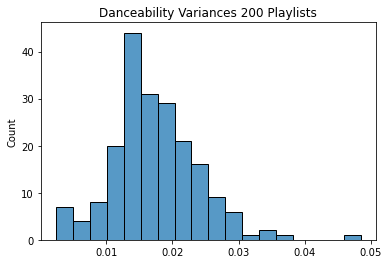

In [74]:
danceability_variances = sns.histplot(feat_vars['danceability']).set(title='Danceability Variances 200 Playlists')

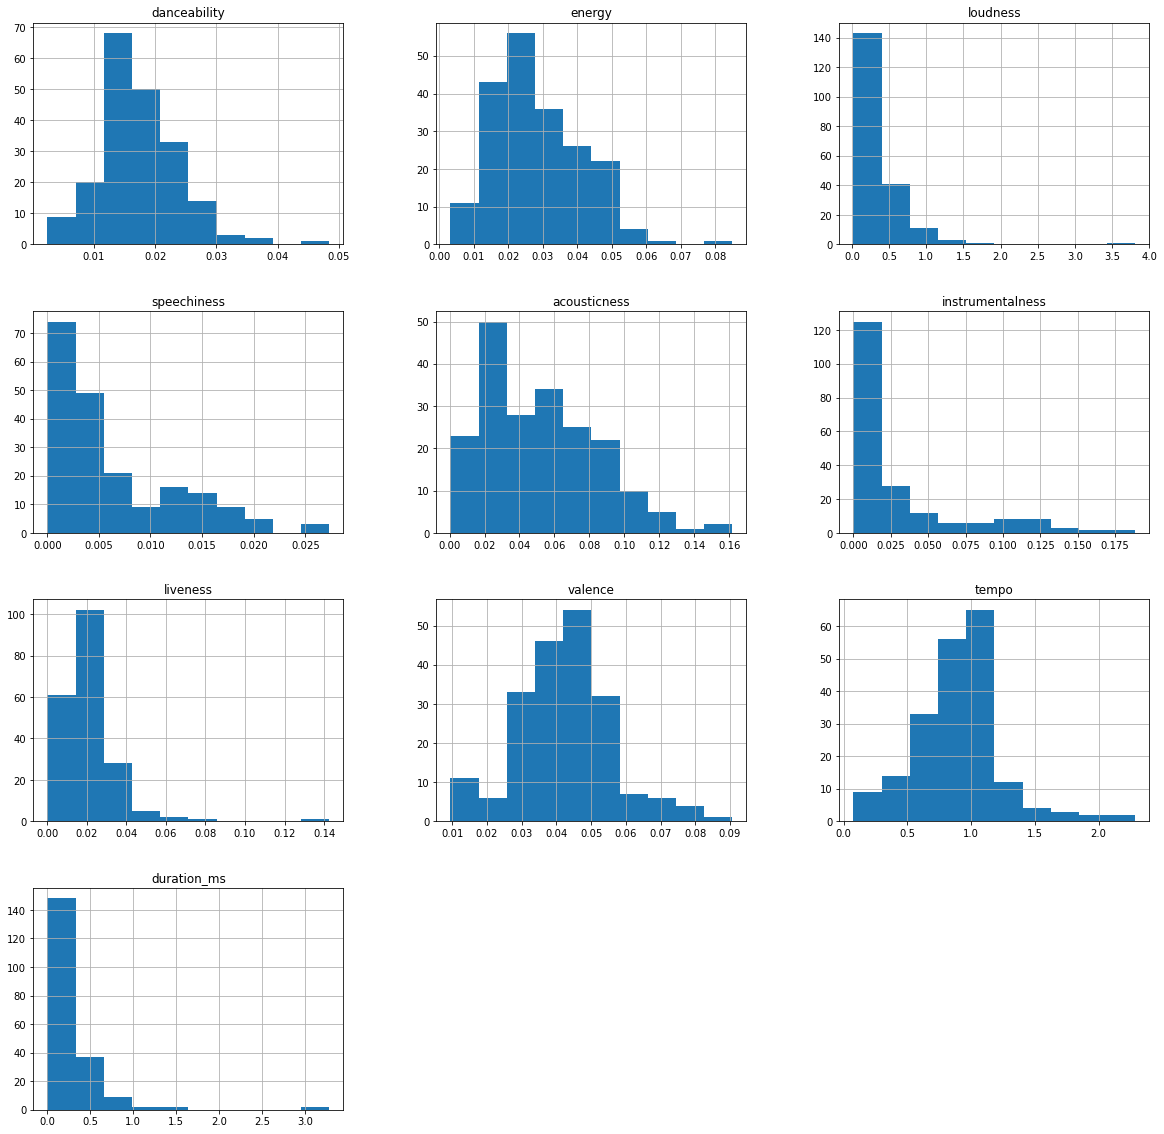

In [75]:
var_hists = pd.DataFrame(feat_vars)[['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']].hist(figsize=(20,20))

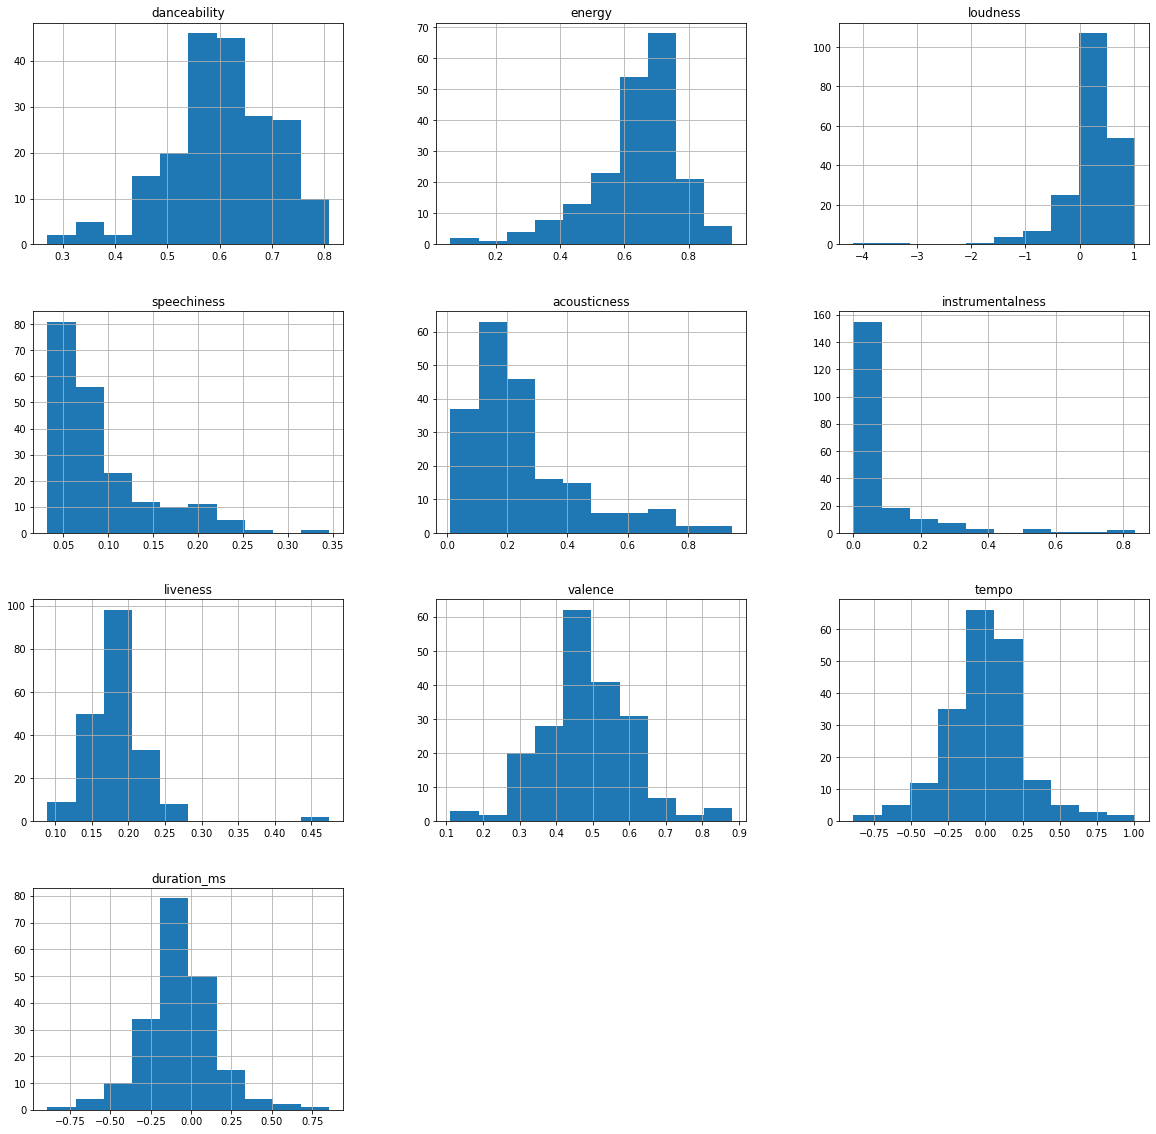

In [76]:
avg_hists = pd.DataFrame(feat_avgs)[['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']].hist(figsize=(20,20))

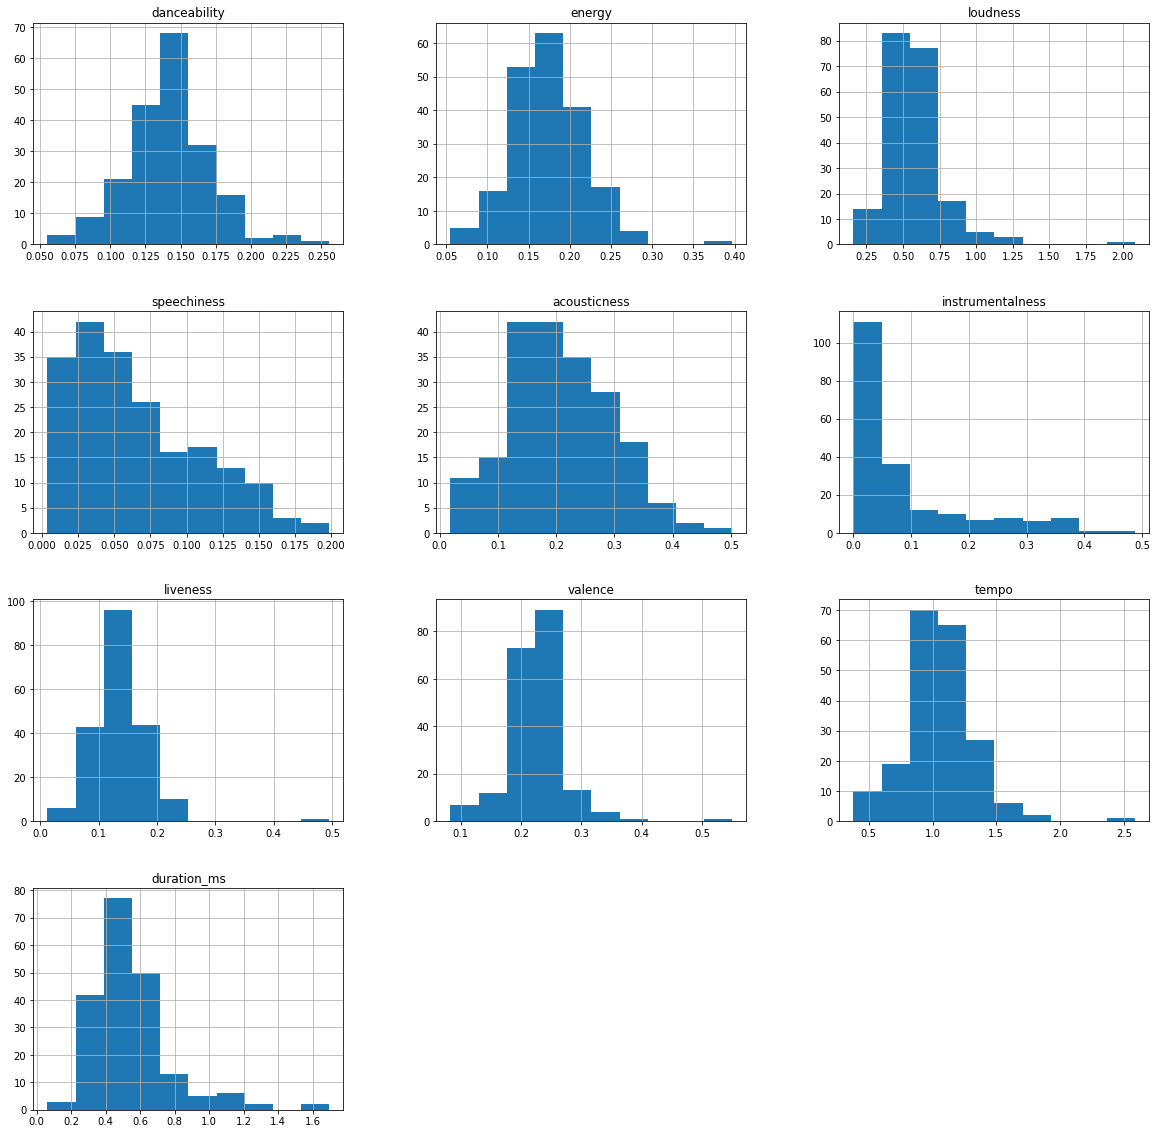

In [78]:
difs_hists = pd.DataFrame(feat_difs)[['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']].hist(figsize=(20,20))

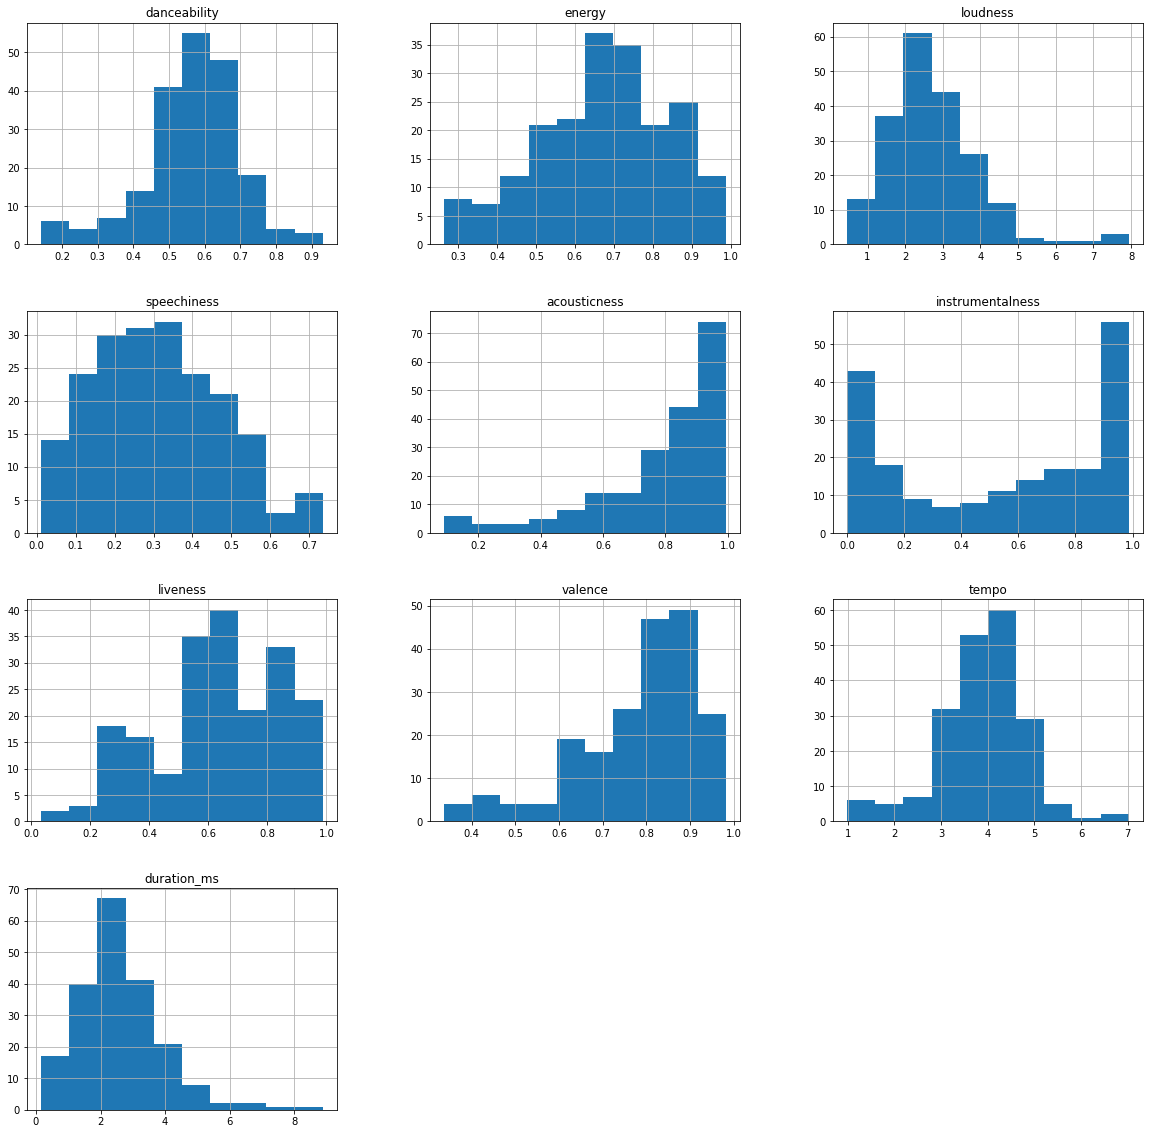

In [79]:
ranges_hists = pd.DataFrame(feat_ranges)[['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']].hist(figsize=(20,20))

# Overall Songs EDA

<AxesSubplot:ylabel='time_signature'>

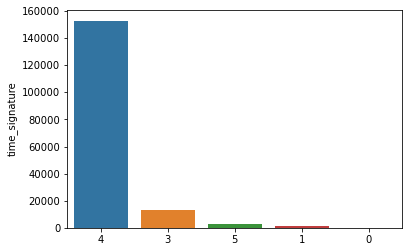

In [25]:
sns.barplot(y=edafeats['time_signature'].value_counts(), x=[str(i) for i in edafeats['time_signature'].value_counts().index])

<AxesSubplot:ylabel='key'>

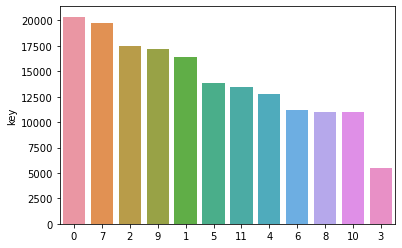

In [26]:
sns.barplot(y=edafeats['key'].value_counts(), x=[str(i) for i in edafeats['key'].value_counts().index])

<AxesSubplot:ylabel='mode'>

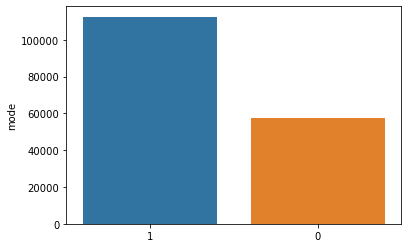

In [27]:
sns.barplot(y=edafeats['mode'].value_counts(), x=[str(i) for i in edafeats['mode'].value_counts().index])

<AxesSubplot:xlabel='energy', ylabel='Count'>

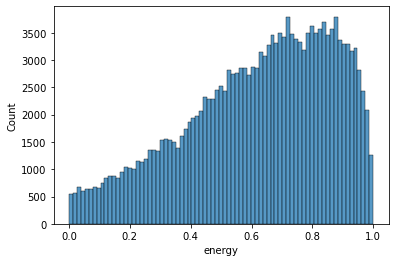

In [28]:
sns.histplot(edafeats['energy'])

<AxesSubplot:xlabel='danceability', ylabel='Count'>

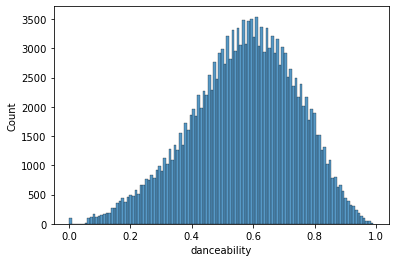

In [29]:
sns.histplot(edafeats['danceability'])

<AxesSubplot:xlabel='loudness', ylabel='Count'>

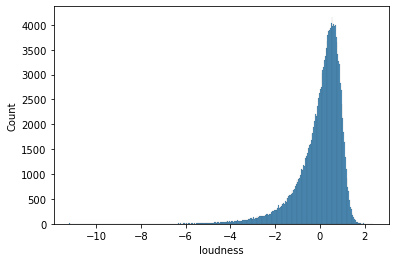

In [30]:
sns.histplot(edafeats['loudness'])

<AxesSubplot:xlabel='speechiness', ylabel='Count'>

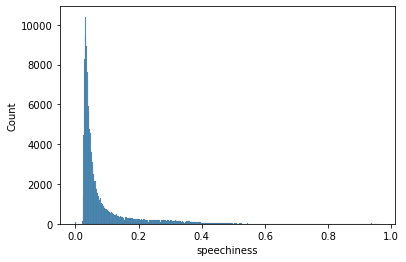

In [31]:
sns.histplot(edafeats['speechiness'])

<AxesSubplot:xlabel='acousticness', ylabel='Count'>

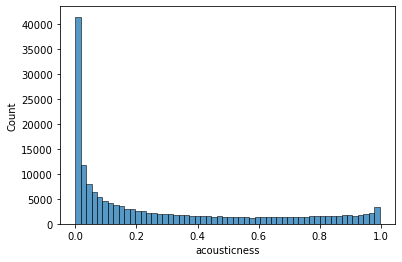

In [32]:
sns.histplot(edafeats['acousticness'])

In [33]:
sns.histplot(features['instrumentalness'])

NameError: name 'features' is not defined

In [ ]:
sns.histplot(edafeats['liveness'])

In [ ]:
sns.histplot(edafeats['valence'])

In [ ]:
sns.histplot(edafeats['tempo'])

In [ ]:
sns.histplot(edafeats['duration_ms'])